In [34]:
import re
import tensorflow as tf
import numpy as np
import collections, math, os, random, zipfile
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from six.moves import urllib, xrange

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

In [48]:

class word2vec:
    
    def __init__(
        self,
        words,
        vocabulary_size = 50000,
        batch_size = 128,
        embedding_size = 128, # dimension of the embedding vector
        skip_window = 1, # how many words to consider to left and right
        num_skips = 2, 
        
        # we choose random validation dataset to sample nearest neighbors
        # here, we limit the validation samples to the words that have a low
        # numeric ID, which are also the most frequently occurring words
        valid_size = 16, # size of random set of words to evaluate similarity on
        valid_window = 100, # only pick development samples from the first 'valid_window' words
        num_sampled = 64, # num
        
        num_steps = 100001, # steps to train the model
        
    ):
        self.vocabulary_size = vocabulary_size
        self.data, self.count, self.dictionary, self.reverse_dictionary = self.build_dataset(words)
        del words
        self.data_index = 0
        
        # hyperparameters
        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.skip_window = skip_window
        self.num_skips = num_skips
        
        # k nearest neighbours parameters
        self.valid_size = valid_size
        self.valid_window = valid_window
        self.valid_examples = np.random.choice(self.valid_window, self.valid_size, replace=False)
        self.num_sampled = num_sampled
        
        self.num_steps = num_steps
        
    
    def build_dataset(self, words):
        count = [['UNK', -1]]
        count.extend(collections.Counter(words).most_common(self.vocabulary_size - 1))
        dictionary = {}
        for word, _ in count:
            dictionary[word] = len(dictionary)
        # create a list data structure for the data
        data = []
        unk_count = 0
        for word in words:
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count += 1
            data.append(index)
        count[0][1] = unk_count
        # invert the dictionary; it becomes (index, word) key-value pairs
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        del words
        
        print('Build dataset from words...COMPLETE')
        print('Most common words (+UNK):', count[:10])
        print('Sample data:', data[:10], [reverse_dictionary[i] for i in data[:10]])
        print()

        return data, count, dictionary, reverse_dictionary
    
    def generate_batch(self, batch_size=None, num_skips=None, skip_window=None):
        
        batch_size = self.batch_size if batch_size is None else batch_size
        num_skips = self.num_skips if num_skips is None else num_skips
        skip_window = self.skip_window if skip_window is None else skip_window
        
        data_index = self.data_index
        data = self.data
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        span = 2 * skip_window + 1  # [ skip_window target skip_window ]
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            context_words = [w for w in range(span) if w != skip_window]
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
            data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)
        return batch, labels
    
    def build_graph(self):
        graph = tf.Graph()
        with graph.as_default():
            # Input data.
            with tf.name_scope('inputs'):
                train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
                train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
                valid_dataset = tf.placeholder(dtype=tf.int32)

            # Look up embeddings for inputs.
            with tf.name_scope('embeddings'):
                embeddings = tf.Variable(tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0))
                embed = tf.nn.embedding_lookup(embeddings, train_inputs)

            # Construct the variables for the NCE loss
            with tf.name_scope('weights'):
                nce_weights = tf.Variable(
                    tf.truncated_normal(
                        [self.vocabulary_size, self.embedding_size],
                        stddev=1.0 / math.sqrt(self.embedding_size)))
            with tf.name_scope('biases'):
                nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))

            # Compute the average NCE loss for the batch.
            # tf.nce_loss automatically draws a new sample of the negative labels each
            # time we evaluate the loss.
            # Explanation of the meaning of NCE loss:
            #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
            with tf.name_scope('loss'):
                loss = tf.reduce_mean(
                    tf.nn.nce_loss(
                        weights = nce_weights,
                        biases = nce_biases,
                        labels = train_labels,
                        inputs = embed,
                        num_sampled = self.num_sampled,
                        num_classes = self.vocabulary_size))

            # Add the loss value as a scalar to summary.
            tf.summary.scalar('loss', loss)

            # Construct the SGD optimizer using a learning rate of 1.0.
            with tf.name_scope('optimizer'):
                optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

            # Compute the cosine similarity between minibatch examples and all embeddings.
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
            normalized_embeddings = embeddings / norm
            valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                                      valid_dataset)
            similarity = tf.matmul(
                valid_embeddings, normalized_embeddings, transpose_b=True)

            # Merge all summaries.
            merged = tf.summary.merge_all()

            # Add variable initializer.
            init = tf.global_variables_initializer()

            # Create a saver.
            saver = tf.train.Saver()

        self.graph = graph
        self.init = init
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        self.valid_dataset = valid_dataset
        self.optimizer = optimizer
        self.loss = loss
        self.similarity = similarity
        self.normalized_embeddings = normalized_embeddings
            
    def train(self):
        num_steps = self.num_steps
        graph = self.graph
        similarity = self.similarity
        init = self.init
        
        session = tf.Session(graph=graph)
        
        print('Training the graph..')
        with session.as_default():
            # we must initialize all variables before using them
            init.run()
            print('initialized.')

            # loop through all training steps and keep track of loss
            average_loss = 0
            for step in xrange(num_steps):
                # generate a minibatch of training data
                batch_inputs, batch_labels = self.generate_batch()
                feed_dict = {self.train_inputs: batch_inputs, self.train_labels: batch_labels}

                # we perform a single update step by evaluating the optimizer operation (including it
                # in the list of returned values of session.run())
                _, loss_val = session.run([self.optimizer, self.loss], feed_dict=feed_dict)
                average_loss += loss_val

                # print average loss every 2,000 steps
                if step % 2000 == 0:
                    if step > 0:
                        average_loss /= 2000
                    # the average loss is an estimate of the loss over the last 2000 batches.
                    print("Average loss at step ", step, ": ", average_loss)
                    average_loss = 0

#                 # computing cosine similarity (expensive!)
#                 if step % 10000 == 0:
#                     sim = similarity.eval(feed_dict={self.valid_dataset: self.valid_examples})
#                     for i in xrange(self.valid_size):
#                         # get a single validation sample
#                         valid_word = self.reverse_dictionary[self.valid_examples[i]]
#                         # number of nearest neighbors
#                         top_k = 8
#                         # computing nearest neighbors
#                         nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#                         log_str = "NEAR {}:".format(valid_word)
#                         for k in xrange(top_k):
#                             close_word = self.reverse_dictionary[nearest[k]]
#                             log_str += " ({}, {})".format(close_word, sim[i,nearest[k]])
#                         print(log_str)

            final_embeddings = self.normalized_embeddings.eval()
        
        self.session = session
        self.final_embeddings = final_embeddings
    
    def plot_with_labels(self, low_dim_embs, labels, filename='tsne.png'):
        assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
        # set plot size in inches
        plt.figure(figsize=(18, 18))
        # loop through all labels
        for i, label in enumerate(labels):
            # get the embedding vectors
            x, y = low_dim_embs[i, :]
            # plot them in a scatterplot
            plt.scatter(x, y)
            # annotations
            plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

        # save the figure out
        # plt.savefig(filename)
        plt.show()
        
    def tsne_plot(self):
        # create the t-SNE object with 2 components, PCA initialization, and 5000 iterations
        tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
        # plot only so many words in the embedding
        plot_only = 500
        # fit the TSNE dimensionality reduction technique to the word vector embedding
        low_dim_embs = tsne.fit_transform(self.final_embeddings[:plot_only, :])
        # get the words associated with the points
        labels = [self.reverse_dictionary[i] for i in xrange(plot_only)]
        # call the plotting function
        self.plot_with_labels(low_dim_embs, labels)
        
    def find_k_closest(self, word, k):
        valid_examples = [self.dictionary[word]]
        with self.session.as_default():
            sim = self.similarity.eval(feed_dict={self.valid_dataset: valid_examples})
            nearest = (-sim[0,:]).argsort()[1:k + 1]
            log_str = 'NEAR {}:'.format(word)
            for i in xrange(k):
                close_word = self.reverse_dictionary[nearest[i]]
                log_str += ' ({}, {})'.format(close_word, round(sim[0,nearest[i]], 2))
            print()
            print(log_str)
    
    def session_cleanup(self):
        self.session.close()

# 20 News Groups

In [49]:
newsgroups = fetch_20newsgroups(data_home='../Data')

In [50]:
# fetch words from all documents
ng_words = []
for doc in newsgroups.data:
    ng_words.extend(list(filter(None, [re.sub("[^a-zA-Z0-9]+", "", w.lower()) for w in doc.split()])))

print('ng words: ', len(ng_words))

ng words:  3135203


In [51]:
ng_w2v = word2vec(ng_words)
ng_w2v.build_graph()
ng_w2v.train()

Build dataset from words...COMPLETE
Most common words (+UNK): [['UNK', 102423], ('the', 146332), ('to', 72647), ('of', 68883), ('a', 60943), ('and', 57452), ('in', 48662), ('is', 43278), ('i', 41559), ('that', 37736)]
Sample data: [13, 43308, 9225, 33, 204, 26, 35, 253, 7, 15] ['from', 'lerxstwamumdedu', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this']

Training the graph..
initialized.
Average loss at step  0 :  254.883453369
Average loss at step  2000 :  96.1592845768
Average loss at step  4000 :  40.69011384
Average loss at step  6000 :  22.8057971148
Average loss at step  8000 :  14.4964585204
Average loss at step  10000 :  9.45267551878
Average loss at step  12000 :  6.39077275734
Average loss at step  14000 :  4.56673250221
Average loss at step  16000 :  3.50530654354
Average loss at step  18000 :  2.53391678229
Average loss at step  20000 :  2.05456931338
Average loss at step  22000 :  1.71391934432
Average loss at step  24000 :  1.3958920005
Average loss at step

In [61]:
ng_w2v.find_k_closest('hi', 20)


NEAR hi: (inhabitants, 0.3499999940395355) (millgram, 0.3499999940395355) (0448, 0.3400000035762787) (nonlife, 0.3400000035762787) (theism, 0.3400000035762787) (bacalzo, 0.3199999928474426) (lyrics, 0.3199999928474426) (roa, 0.3199999928474426) (payload, 0.3100000023841858) (indiciation, 0.3100000023841858) (monty, 0.3100000023841858) (johan, 0.3100000023841858) (flock, 0.3100000023841858) (texts, 0.3100000023841858) (sieferman, 0.30000001192092896) (hispanics, 0.30000001192092896) (hollaschs, 0.30000001192092896) (10h, 0.30000001192092896) (dasp, 0.30000001192092896) (charismatic, 0.30000001192092896)


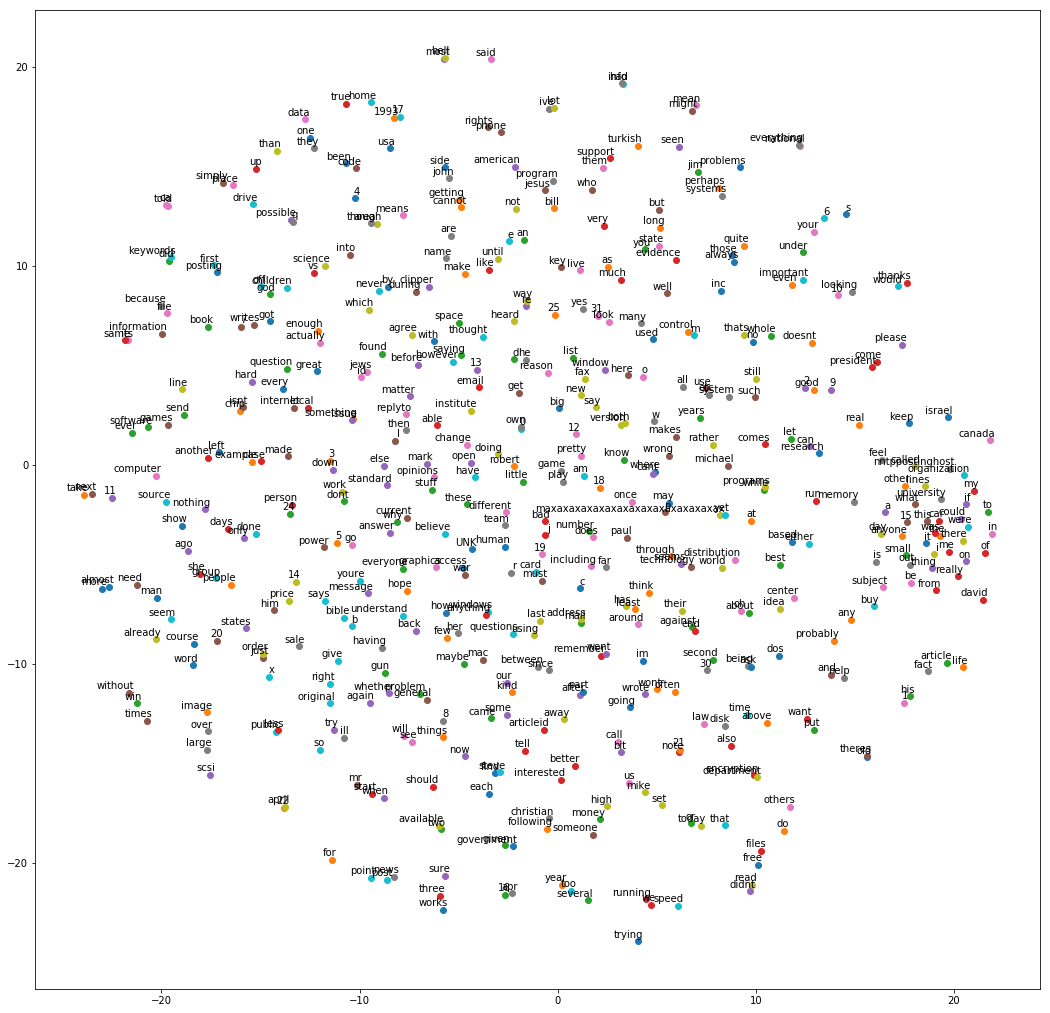

In [53]:
ng_w2v.tsne_plot()

In [ ]:
ng_w2v.session_cleanup()

# Wikipedia

In [43]:
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    local_filename = os.path.join('../Data/', filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                       local_filename)
    statinfo = os.stat(local_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + local_filename +
                        '. Can you get to it with a browser?')
    return local_filename

def read_data(filename):
    """
    Parse the file enclosed in the 'filename' zip file into a list of words.
    """
    # unzip the file
    with zipfile.ZipFile(filename) as f:
        # read the data into the 'data' variable
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    # return the data
    return data

In [44]:
url = 'http://mattmahoney.net/dc/'

filename = maybe_download('text8.zip', 31344016)

wiki_words = read_data(filename)
print('Wiki words', len(wiki_words))

Found and verified text8.zip
Wiki words 17005207


In [54]:
wiki_w2v = word2vec(ng_words)
wiki_w2v.build_graph()
wiki_w2v.train()

Build dataset from words...COMPLETE
Most common words (+UNK): [['UNK', 102423], ('the', 146332), ('to', 72647), ('of', 68883), ('a', 60943), ('and', 57452), ('in', 48662), ('is', 43278), ('i', 41559), ('that', 37736)]
Sample data: [13, 43308, 9225, 33, 204, 26, 35, 253, 7, 15] ['from', 'lerxstwamumdedu', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this']

Training the graph..
initialized.
Average loss at step  0 :  262.969573975
Average loss at step  2000 :  96.6663295169
Average loss at step  4000 :  39.8306669722
Average loss at step  6000 :  22.6467286762
Average loss at step  8000 :  14.3744653276
Average loss at step  10000 :  9.46999647777
Average loss at step  12000 :  6.76069997287
Average loss at step  14000 :  4.56581876156
Average loss at step  16000 :  3.49251533143
Average loss at step  18000 :  2.62362821417
Average loss at step  20000 :  2.11553669487
Average loss at step  22000 :  1.64236488578
Average loss at step  24000 :  1.44555828509
Average loss at s

In [62]:
wiki_w2v.find_k_closest('hi', 20)


NEAR hi: (maintanence, 0.36000001430511475) (int, 0.3499999940395355) (flatpak, 0.3400000035762787) (gamble, 0.3400000035762787) (hayward, 0.3400000035762787) (placenames, 0.33000001311302185) (bearkestrelfslnoaagov, 0.3199999928474426) (gregofjspumontrealca, 0.3199999928474426) (pajukcogecmrc, 0.3199999928474426) (cher, 0.3100000023841858) (compell, 0.3100000023841858) (dpi, 0.3100000023841858) (scif, 0.30000001192092896) (r5, 0.30000001192092896) (159, 0.30000001192092896) (montero, 0.30000001192092896) (marine, 0.30000001192092896) (gritzjbsliberty, 0.30000001192092896) (tim, 0.30000001192092896) (doi, 0.30000001192092896)


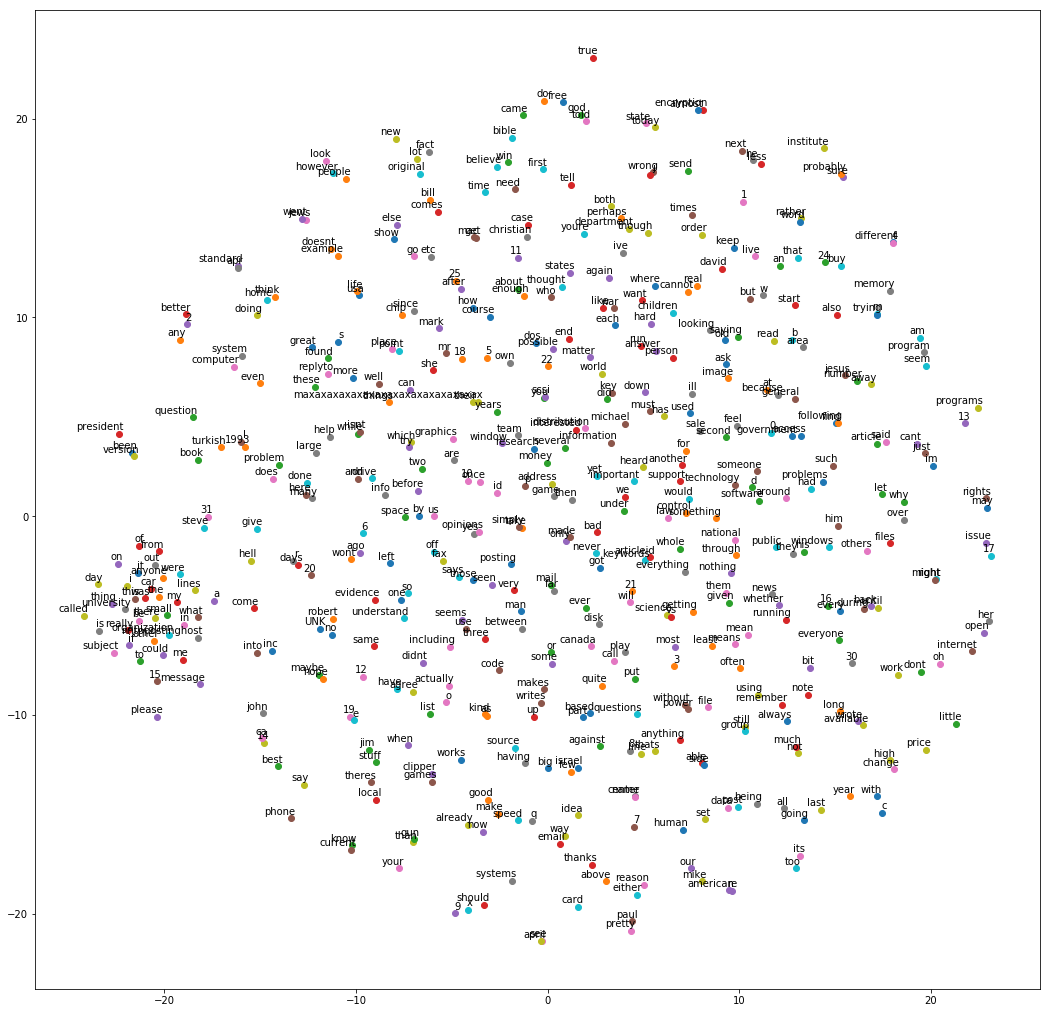

In [56]:
wiki_w2v.tsne_plot()

In [ ]:
wiki_w2v.session_cleanup()